[Here](https://apmonitor.com/do/index.php/Main/TCLabC) is the link for this lab. It involves estimating parameters in a multi-variate energy balance model. The predictions are aligned to the measured values through an optimizer that adjusts the parameters to minimize a sum of squared error objective. This lab builds upon the TCLab B by using the model of two heaters and two temperature sensors.

Initial SSE Objective: 27.74530534002934
Final SSE Objective: 1.8955520510226938
U: 2.297023333477482
alpha1: 0.009157712131941817
alpha2: 0.005036891602502882
Cp: 500.06897947837


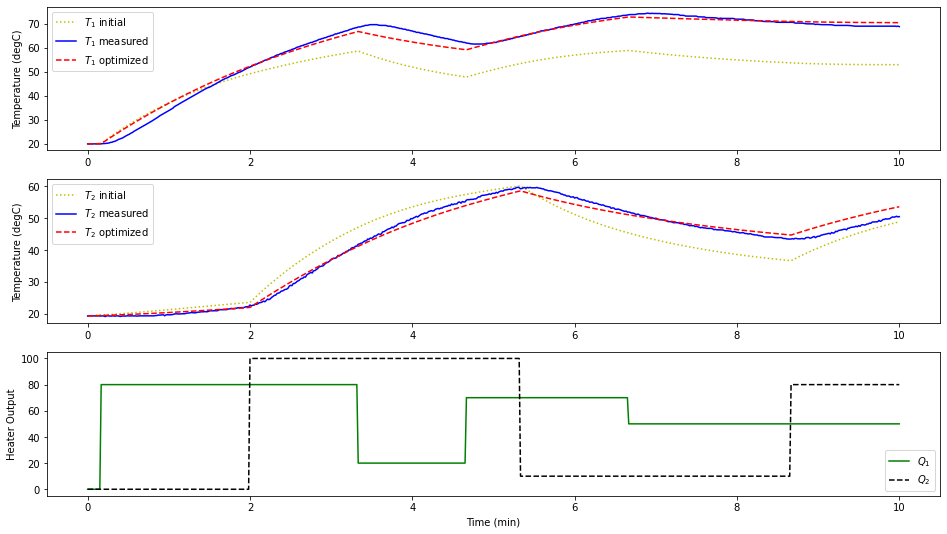

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize
import pandas as pd

# generate data file from TCLab or get sample data file from:
#  https://apmonitor.com/pdc/index.php/Main/ArduinoEstimation2
# Import data file
# Column 1 = time (t)
# Column 2 = input (u)
# Column 3 = output (yp)
data = np.loadtxt('data.txt',delimiter=',',skiprows=1)
# extract data columns
t = data[:,0].T
Q1 = data[:,1].T
Q2 = data[:,2].T
T1meas = data[:,3].T
T2meas = data[:,4].T

# number of time points
ns = len(t)

# define energy balance model
def heat(x,t,Q1,Q2,p):
    # Optimized parameters
    U,alpha1,alpha2,Cp = p

    # Parameters
    Ta = 23 + 273.15   # K
    m = 4.0/1000.0     # kg
    A = 10.0 / 100.0**2 # Area in m^2
    As = 2.0 / 100.0**2 # Area in m^2
    eps = 0.9          # Emissivity
    sigma = 5.67e-8    # Stefan-Boltzman

    # Temperature States
    T1 = x[0] + 273.15
    T2 = x[1] + 273.15

    # Heat Transfer Exchange Between 1 and 2
    conv12 = U*As*(T2-T1)
    rad12  = eps*sigma*As * (T2**4 - T1**4)

    # Nonlinear Energy Balances
    dT1dt = (1.0/(m*Cp))*(U*A*(Ta-T1) \
            + eps * sigma * A * (Ta**4 - T1**4) \
            + conv12 + rad12 \
            + alpha1*Q1)
    dT2dt = (1.0/(m*Cp))*(U*A*(Ta-T2) \
            + eps * sigma * A * (Ta**4 - T2**4) \
            - conv12 - rad12 \
            + alpha2*Q2)

    return [dT1dt,dT2dt]

def simulate(p):
    T = np.zeros((len(t),2))
    T[0,0] = T1meas[0]
    T[0,1] = T2meas[0]    
    T0 = T[0]
    for i in range(len(t)-1):
        ts = [t[i],t[i+1]]
        y = odeint(heat,T0,ts,args=(Q1[i],Q2[i],p))
        T0 = y[-1]
        T[i+1] = T0
    return T

# define objective
def objective(p):
    # simulate model
    Tp = simulate(p)
    # calculate objective
    obj = 0.0
    for i in range(len(t)):
        obj += ((Tp[i,0]-T1meas[i])/T1meas[i])**2 \
              +((Tp[i,1]-T2meas[i])/T2meas[i])**2
    # return result
    return obj

# Parameter initial guess
U = 10.0           # Heat transfer coefficient (W/m^2-K)
alpha1 = 0.0100    # Heat gain 1 (W/%)
alpha2 = 0.0075    # Heat gain 2 (W/%)
Cp = 500           #heat capacity
p0 = [U,alpha1,alpha2,Cp]

# show initial objective
print('Initial SSE Objective: ' + str(objective(p0)))

# optimize parameters
# bounds on variables
bnds = ((2.0, 20.0),(0.005,0.02),(0.002,0.015),(1.0,1000.0))
solution = minimize(objective,p0,method='SLSQP',bounds=bnds)
p = solution.x

# show final objective
print('Final SSE Objective: ' + str(objective(p)))

# optimized parameter values
U = p[0]
alpha1 = p[1]
alpha2 = p[2]
Cp = p[3]
print('U: ' + str(U))
print('alpha1: ' + str(alpha1))
print('alpha2: ' + str(alpha2))
print('Cp: ' + str(Cp))

# calculate model with updated parameters
Ti  = simulate(p0)
Tp  = simulate(p)

# Plot results
plt.figure(1, figsize=(16,9))

plt.subplot(3,1,1)
plt.plot(t/60.0,Ti[:,0],'y:',label=r'$T_1$ initial')
plt.plot(t/60.0,T1meas,'b-',label=r'$T_1$ measured')
plt.plot(t/60.0,Tp[:,0],'r--',label=r'$T_1$ optimized')
plt.ylabel('Temperature (degC)')
plt.legend(loc='best')

plt.subplot(3,1,2)
plt.plot(t/60.0,Ti[:,1],'y:',label=r'$T_2$ initial')
plt.plot(t/60.0,T2meas,'b-',label=r'$T_2$ measured')
plt.plot(t/60.0,Tp[:,1],'r--',label=r'$T_2$ optimized')
plt.ylabel('Temperature (degC)')
plt.legend(loc='best')

plt.subplot(3,1,3)
plt.plot(t/60.0,Q1,'g-',label=r'$Q_1$')
plt.plot(t/60.0,Q2,'k--',label=r'$Q_2$')
plt.ylabel('Heater Output')
plt.legend(loc='best')

plt.xlabel('Time (min)')
plt.show()

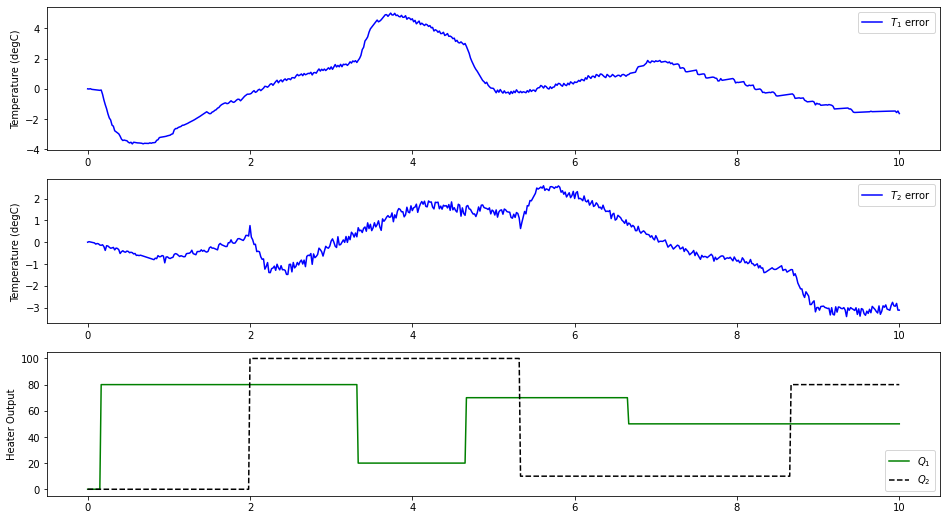

In [8]:
plt.figure(figsize=(16,9))
plt.subplot(3,1,1)
plt.plot(t/60.0,T1meas - Tp[:,0],'b-',label=r'$T_1$ error')
plt.ylabel('Temperature (degC)')
plt.legend(loc='best')

plt.subplot(3,1,2)
plt.plot(t/60.0,T2meas - Tp[:,1],'b-',label=r'$T_2$ error')
plt.ylabel('Temperature (degC)')
plt.legend(loc='best')

plt.subplot(3,1,3)
plt.plot(t/60.0,Q1,'g-',label=r'$Q_1$')
plt.plot(t/60.0,Q2,'k--',label=r'$Q_2$')
plt.ylabel('Heater Output')
plt.legend(loc='best')

## Questions

1) What parameter(s) would be unobservable (not able to estimate) if only heater 1 was active and heater 2 was off during the entire data collection?
    * $\alpha_2$ (since it only shows up in T2 dynamics through the heater input)

2) Why have step changes in the heaters that persist before another change and not random values at every time point or more frequent changes?
    * It gives us a chance to estimate time response for this system. If the system dynamics were faster, we could use faster input trajectories. But sending inputs too quickly doesn't give the dynamics a chance to 'show' themselves. It would likely be a good idea to send in a frequency sweep (that might give us better estimates than inputs at just one frequency. Thinking bode plots.)

3) With optimized parameters, how well does the model fit the steady state (overall change magnitude) response? How well does the model fit the transient response immediately after a step change in the heaters?
    * It seems like the optmized trajectory responds too quickly (i.e. the optmized reponse moved before the data does.) There might be some sort of delay (like on serial transmission or in sensors) we aren't modeling, so we can't fit to that. The data we got doesnt really get to steady state entirely, but it looks like the fit model is doing a much better job steady state. 

